<a href="https://colab.research.google.com/github/iamsurajkumar/Empirical-Macroeconomics/blob/main/nk_causal_transformer_irf_diagnostics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Transformer Learns a Simple NK Model (Diagnostics + IRF Evaluation)

This notebook implements three changes versus a naïve encoder-only Transformer setup:

1. **Causal attention mask** (no access to future shocks when predicting $y_t$)
2. **Diagnostics** (numerical conditioning checks, rejection counts, per-variable errors, oracle sanity check)
3. **IRF-based evaluation** (truth vs prediction impulse response panels)

The data come from a small linear New Keynesian (NK) model solved into a reduced-form policy matrix $P(\theta)$.

In [ ]:

# --- Imports / Setup ---
import math
import random
from dataclasses import dataclass
from typing import List

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt

# Reproducibility
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


## 1) NK Model and Solution

We solve a reduced-form mapping $y_t = P(\theta) s_t$ where $y_t=[x_t,\pi_t,i_t]'$ and $s_t=[r_t^n,u_t,\varepsilon_t^i]'$.

We compute $P(\theta)$ by solving a 9×9 Kronecker linear system. We also record a **condition number** diagnostic for numerical stability.

In [ ]:

@dataclass
class NKParams:
    beta: float
    sigma: float
    kappa: float
    phi_pi: float
    phi_x: float
    rho_r: float
    rho_u: float
    rho_i: float

    def as_array(self) -> np.ndarray:
        return np.array(
            [self.beta, self.sigma, self.kappa,
             self.phi_pi, self.phi_x,
             self.rho_r, self.rho_u, self.rho_i],
            dtype=np.float32
        )


def random_nk_params() -> NKParams:
    # simple priors
    beta = np.random.uniform(0.9, 0.99)
    sigma = np.random.uniform(0.5, 3.0)
    kappa = np.random.uniform(0.05, 0.3)
    phi_pi = np.random.uniform(1.2, 2.5)
    phi_x = np.random.uniform(0.0, 1.0)
    rho_r = np.random.uniform(0.5, 0.95)
    rho_u = np.random.uniform(0.5, 0.95)
    rho_i = np.random.uniform(0.5, 0.95)
    return NKParams(beta, sigma, kappa, phi_pi, phi_x, rho_r, rho_u, rho_i)


def solve_policy_matrix(params: NKParams, return_diagnostics: bool = False):
    '''
    Solve for P in y_t = P s_t by solving:
        (kron(R.T, A) - kron(I, B)) vec(P) = vec(C)

    Returns:
      P: (3,3) float32
      diagnostics: {"condM": float} (optional)
    '''
    beta = params.beta
    sigma = params.sigma
    kappa = params.kappa
    phi_pi = params.phi_pi
    phi_x = params.phi_x
    rho_r = params.rho_r
    rho_u = params.rho_u
    rho_i = params.rho_i

    A = np.array([
        [-1.0,    -1.0 / sigma,  0.0],
        [ 0.0,    -beta,         0.0],
        [ 0.0,     0.0,          0.0]
    ], dtype=np.float64)

    B = np.array([
        [ 1.0,      0.0,        1.0 / sigma],
        [-kappa,    1.0,        0.0],
        [-phi_x,   -phi_pi,     1.0]
    ], dtype=np.float64)

    C = np.array([
        [-1.0 / sigma,  0.0,  0.0],
        [ 0.0,         -1.0,  0.0],
        [ 0.0,          0.0, -1.0]
    ], dtype=np.float64)

    R = np.diag([rho_r, rho_u, rho_i]).astype(np.float64)
    I3 = np.eye(3, dtype=np.float64)

    M = np.kron(R.T, A) - np.kron(I3, B)
    vecC = C.reshape(-1, order="F")

    condM = float(np.linalg.cond(M))
    vecP = np.linalg.solve(M, vecC)  # may raise LinAlgError
    P = vecP.reshape(3, 3, order="F").astype(np.float32)

    if return_diagnostics:
        return P, {"condM": condM}
    return P


## 2) Data Generation + Dataset

We simulate sequences from exogenous AR(1) innovations and the solved policy matrix. We reject parameter draws with ill-conditioned solves (large condition number).

In [ ]:

@dataclass
class SequenceExample:
    theta: np.ndarray
    innovations: np.ndarray  # (T,3)
    targets: np.ndarray      # (T,3)


def simulate_sequence(params: NKParams,
                      T: int = 64,
                      sigma_r: float = 0.1,
                      sigma_u: float = 0.1,
                      sigma_i: float = 0.1,
                      cond_thresh: float = 1e10) -> SequenceExample:
    P, diag = solve_policy_matrix(params, return_diagnostics=True)
    if (not np.isfinite(diag["condM"])) or (diag["condM"] > cond_thresh):
        raise np.linalg.LinAlgError(f"Ill-conditioned solve: cond(M)={diag['condM']:.2e}")

    R = np.diag([params.rho_r, params.rho_u, params.rho_i]).astype(np.float32)
    Sigma = np.diag([sigma_r, sigma_u, sigma_i]).astype(np.float32)

    s = np.zeros(3, dtype=np.float32)
    innovations = np.zeros((T, 3), dtype=np.float32)
    targets = np.zeros((T, 3), dtype=np.float32)

    for t in range(T):
        eta = np.random.randn(3).astype(np.float32)
        innovations[t] = eta
        s = R @ s + Sigma @ eta
        targets[t] = P @ s

    return SequenceExample(params.as_array(), innovations, targets)


class NKDataset(Dataset):
    def __init__(self, param_list: List[NKParams], sequences_per_param: int = 10, T: int = 64, cond_thresh: float = 1e10):
        super().__init__()
        self.examples: List[SequenceExample] = []
        self.n_rejected = 0

        for params in param_list:
            for _ in range(sequences_per_param):
                try:
                    self.examples.append(simulate_sequence(params, T=T, cond_thresh=cond_thresh))
                except (np.linalg.LinAlgError, FloatingPointError, ValueError):
                    self.n_rejected += 1

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx: int):
        ex = self.examples[idx]
        T = ex.innovations.shape[0]
        theta_tiled = np.tile(ex.theta[None, :], (T, 1)).astype(np.float32)   # (T,8)
        x = np.concatenate([theta_tiled, ex.innovations], axis=-1).astype(np.float32)  # (T,11)
        y = ex.targets.astype(np.float32)  # (T,3)
        return torch.from_numpy(x), torch.from_numpy(y)


def make_param_splits(n_total: int, train_frac: float = 0.7, val_frac: float = 0.15):
    params = [random_nk_params() for _ in range(n_total)]
    random.shuffle(params)
    n_train = int(n_total * train_frac)
    n_val = int(n_total * val_frac)
    return params[:n_train], params[n_train:n_train+n_val], params[n_train+n_val:]


## 3) Normalization + Metrics

We standardize inputs/targets based on training data and report per-variable MSE in original units.

In [ ]:

from dataclasses import dataclass

@dataclass
class Normalizer:
    x_mean: torch.Tensor
    x_std: torch.Tensor
    y_mean: torch.Tensor
    y_std: torch.Tensor

def fit_normalizer(loader, d_in: int, d_out: int, device=device) -> Normalizer:
    sx = torch.zeros(d_in, device=device)
    sx2 = torch.zeros(d_in, device=device)
    sy = torch.zeros(d_out, device=device)
    sy2 = torch.zeros(d_out, device=device)
    n = 0

    for xb, yb in loader:
        xb = xb.to(device)  # (B,T,d_in)
        yb = yb.to(device)
        xflat = xb.reshape(-1, d_in)
        yflat = yb.reshape(-1, d_out)
        n_batch = xflat.shape[0]
        sx += xflat.sum(0)
        sx2 += (xflat**2).sum(0)
        sy += yflat.sum(0)
        sy2 += (yflat**2).sum(0)
        n += n_batch

    x_mean = sx / n
    y_mean = sy / n
    x_var = (sx2 / n) - x_mean**2
    y_var = (sy2 / n) - y_mean**2
    x_std = torch.sqrt(torch.clamp(x_var, min=1e-12))
    y_std = torch.sqrt(torch.clamp(y_var, min=1e-12))
    return Normalizer(x_mean, x_std, y_mean, y_std)

def normalize_batch(xb, yb, norm: Normalizer, device=device):
    xb = xb.to(device)
    yb = yb.to(device)
    xb_n = (xb - norm.x_mean) / norm.x_std
    yb_n = (yb - norm.y_mean) / norm.y_std
    return xb, yb, xb_n, yb_n

@torch.no_grad()
def unnormalize_y(y_n, norm: Normalizer):
    return y_n * norm.y_std + norm.y_mean

def mse_by_var(y_pred, y_true):
    return ((y_pred - y_true)**2).mean(dim=(0,1))


## 4) Causal Transformer

We apply an upper-triangular attention mask so time $t$ cannot attend to times $>t$.

In [ ]:

class PositionalEncodingBF(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model, dtype=torch.float32)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1,max_len,d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        T = x.size(1)
        return x + self.pe[:, :T, :]

def causal_attn_mask(T: int, device):
    mask = torch.full((T, T), float("-inf"), device=device)
    return torch.triu(mask, diagonal=1)

class NKTransformerCausal(nn.Module):
    def __init__(self, d_in: int, d_model: int = 64, nhead: int = 4, num_layers: int = 4,
                 d_ff: int = 128, d_out: int = 3, dropout: float = 0.1):
        super().__init__()
        self.input_proj = nn.Linear(d_in, d_model)
        self.pos = PositionalEncodingBF(d_model)
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_ff,
                                           dropout=dropout, batch_first=True)
        self.enc = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.out = nn.Linear(d_model, d_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.input_proj(x)
        h = self.pos(h)
        T = h.size(1)
        mask = causal_attn_mask(T, h.device)
        try:
            h = self.enc(h, mask=mask)
        except TypeError:
            h = self.enc(h, src_mask=mask)
        return self.out(h)


## 5) Training + Evaluation + Oracle Sanity Check

We train on normalized targets, but report validation/test MSE in original units. We also compute an **oracle** prediction using the NK solution to ensure the data pipeline is consistent.

In [ ]:

def train_model(model, train_loader, val_loader, norm: Normalizer, device=device,
                lr: float = 1e-3, epochs: int = 20, clip: float = 1.0):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = float("inf")
    best_state = None

    for ep in range(1, epochs + 1):
        model.train()
        tr_loss = 0.0
        n_tr = 0

        for xb, yb in train_loader:
            xb, yb, xb_n, yb_n = normalize_batch(xb, yb, norm, device)
            opt.zero_grad()
            yhat_n = model(xb_n)
            loss = ((yhat_n - yb_n)**2).mean()
            loss.backward()
            if clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()
            tr_loss += loss.item() * xb.size(0)
            n_tr += xb.size(0)

        # Validation in original units
        model.eval()
        val_loss = 0.0
        n_val = 0
        pervar = torch.zeros(3, device=device)
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb, xb_n, _ = normalize_batch(xb, yb, norm, device)
                yhat_n = model(xb_n)
                yhat = unnormalize_y(yhat_n, norm)
                val_loss += ((yhat - yb)**2).mean().item() * xb.size(0)
                pervar += mse_by_var(yhat, yb) * xb.size(0)
                n_val += xb.size(0)

        val_loss /= max(n_val, 1)
        pervar = (pervar / max(n_val, 1)).detach().cpu().numpy()

        print(f"Epoch {ep:3d} | train (normed MSE): {tr_loss/max(n_tr,1):.6f} | "
              f"val MSE (orig): {val_loss:.6f} | per-var x={pervar[0]:.6f}, pi={pervar[1]:.6f}, i={pervar[2]:.6f}")

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val

@torch.no_grad()
def eval_model(model, loader, norm: Normalizer, device=device, name="model"):
    model.eval()
    total = 0.0
    n = 0
    pervar = torch.zeros(3, device=device)
    for xb, yb in loader:
        xb, yb, xb_n, _ = normalize_batch(xb, yb, norm, device)
        yhat_n = model(xb_n)
        yhat = unnormalize_y(yhat_n, norm)
        total += ((yhat - yb)**2).mean().item() * xb.size(0)
        pervar += mse_by_var(yhat, yb) * xb.size(0)
        n += xb.size(0)
    total /= max(n, 1)
    pervar = (pervar / max(n, 1)).detach().cpu().numpy()
    print(f"{name}: MSE={total:.6f} | per-var x={pervar[0]:.6f}, pi={pervar[1]:.6f}, i={pervar[2]:.6f}")
    return total, pervar

@torch.no_grad()
def oracle_predict_from_inputs(xb: torch.Tensor, sigma_r=0.1, sigma_u=0.1, sigma_i=0.1) -> torch.Tensor:
    xb_np = xb.detach().cpu().numpy()
    B, T, _ = xb_np.shape
    yhat = np.zeros((B, T, 3), dtype=np.float32)
    Sigma = np.diag([sigma_r, sigma_u, sigma_i]).astype(np.float32)

    for b in range(B):
        theta = xb_np[b, 0, :8]
        p = NKParams(
            beta=float(theta[0]), sigma=float(theta[1]), kappa=float(theta[2]),
            phi_pi=float(theta[3]), phi_x=float(theta[4]),
            rho_r=float(theta[5]), rho_u=float(theta[6]), rho_i=float(theta[7]),
        )
        P = solve_policy_matrix(p)
        R = np.diag([p.rho_r, p.rho_u, p.rho_i]).astype(np.float32)

        s = np.zeros(3, dtype=np.float32)
        for t in range(T):
            eta = xb_np[b, t, 8:11].astype(np.float32)
            s = R @ s + Sigma @ eta
            yhat[b, t] = P @ s

    return torch.from_numpy(yhat)

@torch.no_grad()
def eval_oracle(loader, device=device):
    total = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        yhat = oracle_predict_from_inputs(xb).to(device)
        total += ((yhat - yb)**2).mean().item() * xb.size(0)
        n += xb.size(0)
    mse = total / max(n, 1)
    print(f"Oracle MSE={mse:.12f} (should be ~0 up to float error)")
    return mse


## 6) Run the Experiment (Causal Transformer Only)

This cell builds datasets/loaders, prints rejection diagnostics, fits a normalizer, trains the causal Transformer, and evaluates test + oracle.

In [ ]:

# --- Hyperparameters ---
n_param_total = 200
sequences_per_param = 10
T = 64
batch_size = 32
num_epochs = 20

d_in = 11
d_model = 64
nhead = 4
num_layers = 4
d_ff = 128
dropout = 0.1
lr = 1e-3

cond_thresh = 1e10

# Split by theta
train_params, val_params, test_params = make_param_splits(n_param_total)
print(f"Train thetas={len(train_params)} | Val thetas={len(val_params)} | Test thetas={len(test_params)}")

# Datasets
train_ds = NKDataset(train_params, sequences_per_param=sequences_per_param, T=T, cond_thresh=cond_thresh)
val_ds   = NKDataset(val_params,   sequences_per_param=sequences_per_param, T=T, cond_thresh=cond_thresh)
test_ds  = NKDataset(test_params,  sequences_per_param=sequences_per_param, T=T, cond_thresh=cond_thresh)

print(f"Train sequences: {len(train_ds)} (rejected {train_ds.n_rejected})")
print(f"Val sequences:   {len(val_ds)}   (rejected {val_ds.n_rejected})")
print(f"Test sequences:  {len(test_ds)}  (rejected {test_ds.n_rejected})")

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# Normalizer from training data
norm = fit_normalizer(DataLoader(train_ds, batch_size=batch_size, shuffle=False), d_in=d_in, d_out=3, device=device)
print("Fitted normalizer.")

# Model
model = NKTransformerCausal(d_in=d_in, d_model=d_model, nhead=nhead, num_layers=num_layers,
                            d_ff=d_ff, d_out=3, dropout=dropout).to(device)

# quick mask/forward sanity
xb0, yb0 = next(iter(train_loader))
xb0 = xb0.to(device)
xb0_n = (xb0 - norm.x_mean) / norm.x_std
with torch.no_grad():
    _ = model(xb0_n)
print("Causal forward pass OK (mask applied).")

# Train
model, best_val = train_model(model, train_loader, val_loader, norm, device=device, lr=lr, epochs=num_epochs, clip=1.0)

# Evaluate
print("\n=== Test ===")
eval_model(model, test_loader, norm, device=device, name="Causal Transformer (test)")
eval_oracle(test_loader, device=device)


Train thetas=140 | Val thetas=30 | Test thetas=30
Train sequences: 1400 (rejected 0)
Val sequences:   300   (rejected 0)
Test sequences:  300  (rejected 0)
Fitted normalizer.
Causal forward pass OK (mask applied).
Epoch   1 | train (normed MSE): 0.751285 | val MSE (orig): 0.010470 | per-var x=0.006130, pi=0.004339, i=0.020941
Epoch   2 | train (normed MSE): 0.422288 | val MSE (orig): 0.004507 | per-var x=0.002508, pi=0.001742, i=0.009271
Epoch   3 | train (normed MSE): 0.239598 | val MSE (orig): 0.003050 | per-var x=0.001601, pi=0.001063, i=0.006485
Epoch   4 | train (normed MSE): 0.174621 | val MSE (orig): 0.002424 | per-var x=0.001544, pi=0.000748, i=0.004981
Epoch   5 | train (normed MSE): 0.130917 | val MSE (orig): 0.002150 | per-var x=0.001499, pi=0.000633, i=0.004317
Epoch   6 | train (normed MSE): 0.130015 | val MSE (orig): 0.001665 | per-var x=0.001001, pi=0.000491, i=0.003504
Epoch   7 | train (normed MSE): 0.105620 | val MSE (orig): 0.001305 | per-var x=0.000839, pi=0.000385,

5.3174335406141936e-17

## 7) Conditioning Diagnostics

If you see many rejected sequences, inspect the conditioning distribution.

cond(M): median 3.940961976659466 p90 5.191186065866587 max 8.02286208899781


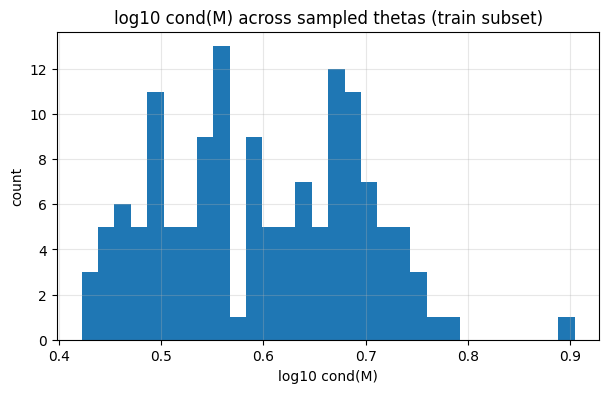

In [ ]:

conds = []
for p in train_params[:200]:
    try:
        _, d = solve_policy_matrix(p, return_diagnostics=True)
        if np.isfinite(d["condM"]):
            conds.append(d["condM"])
    except np.linalg.LinAlgError:
        pass

conds = np.array(conds)
print("cond(M): median", float(np.median(conds)), "p90", float(np.quantile(conds, 0.9)), "max", float(np.max(conds)))

plt.figure(figsize=(7,4))
plt.hist(np.log10(conds), bins=30)
plt.title("log10 cond(M) across sampled thetas (train subset)")
plt.xlabel("log10 cond(M)")
plt.ylabel("count")
plt.grid(True, alpha=0.3)
plt.show()


## 8) IRF-Based Evaluation Panel

We compute IRFs for each shock (impulse at t=0, zeros after) and plot truth vs prediction in a 3×3 panel.

In [ ]:

def irf_truth(params: NKParams, H: int = 40, shock_idx: int = 2,
              impulse: float = 1.0, sigma_r=0.1, sigma_u=0.1, sigma_i=0.1):
    P = solve_policy_matrix(params)
    R = np.diag([params.rho_r, params.rho_u, params.rho_i]).astype(np.float32)
    Sigma = np.diag([sigma_r, sigma_u, sigma_i]).astype(np.float32)

    innovations = np.zeros((H, 3), dtype=np.float32)
    innovations[0, shock_idx] = impulse

    s = np.zeros(3, dtype=np.float32)
    y = np.zeros((H, 3), dtype=np.float32)
    for t in range(H):
        eta = innovations[t]
        s = R @ s + Sigma @ eta
        y[t] = P @ s
    return innovations, y

@torch.no_grad()
def irf_pred(model, norm: Normalizer, params: NKParams, H: int = 40, shock_idx: int = 2,
             impulse: float = 1.0, device=device):
    innovations, y_true = irf_truth(params, H=H, shock_idx=shock_idx, impulse=impulse)

    theta = params.as_array()
    theta_tiled = np.tile(theta[None, :], (H, 1)).astype(np.float32)
    x_in = np.concatenate([theta_tiled, innovations], axis=-1).astype(np.float32)  # (H,11)

    xb = torch.from_numpy(x_in).unsqueeze(0).to(device)  # (1,H,11)
    xb_n = (xb - norm.x_mean) / norm.x_std

    model.eval()
    yhat_n = model(xb_n)
    yhat = (yhat_n * norm.y_std + norm.y_mean).detach().cpu().numpy()[0]  # (H,3)
    return y_true, yhat

def plot_irf_panel(model, norm: Normalizer, params: NKParams, H: int = 40, impulse: float = 1.0, device=device):
    shock_names = ["Natural rate (r^n)", "Cost-push (u)", "Policy shock (eps^i)"]
    var_names = ["Output gap x", "Inflation pi", "Interest rate i"]

    fig, axes = plt.subplots(3, 3, figsize=(12, 9), sharex=True)
    t = np.arange(H)

    total_mse = 0.0
    for col in range(3):
        y_true, y_pred = irf_pred(model, norm, params, H=H, shock_idx=col, impulse=impulse, device=device)
        total_mse += float(np.mean((y_true - y_pred) ** 2))
        for row in range(3):
            ax = axes[row, col]
            ax.plot(t, y_true[:, row], label="Truth")
            ax.plot(t, y_pred[:, row], "--", label="Pred")
            if row == 0:
                ax.set_title(shock_names[col])
            if col == 0:
                ax.set_ylabel(var_names[row])
            ax.grid(True, alpha=0.3)

    axes[0,0].legend()
    fig.suptitle("IRF panel: truth vs causal Transformer prediction", y=1.02)
    plt.tight_layout()
    plt.show()

    avg_mse = total_mse / 3.0
    print(f"Avg IRF MSE across 3 shocks: {avg_mse:.6f}")
    return avg_mse

@torch.no_grad()
def irf_score_over_test(model, norm: Normalizer, test_params: List[NKParams], H: int = 40, impulse: float = 1.0, device=device):
    mses = []
    for p in test_params:
        mse_shocks = 0.0
        for shock_idx in range(3):
            y_true, y_pred = irf_pred(model, norm, p, H=H, shock_idx=shock_idx, impulse=impulse, device=device)
            mse_shocks += float(np.mean((y_true - y_pred) ** 2))
        mses.append(mse_shocks / 3.0)
    mses = np.array(mses)
    print(f"IRF score across holdout thetas | mean={mses.mean():.6f} median={np.median(mses):.6f} p90={np.quantile(mses,0.9):.6f}")
    return mses


### Run IRF Evaluation

Random holdout theta: NKParams(beta=0.9385512547230854, sigma=1.0113571488660693, kappa=0.16265912262968368, phi_pi=1.9120926444175101, phi_x=0.09332671036982076, rho_r=0.6335873489663058, rho_u=0.9174129080684663, rho_i=0.7560516791435878)


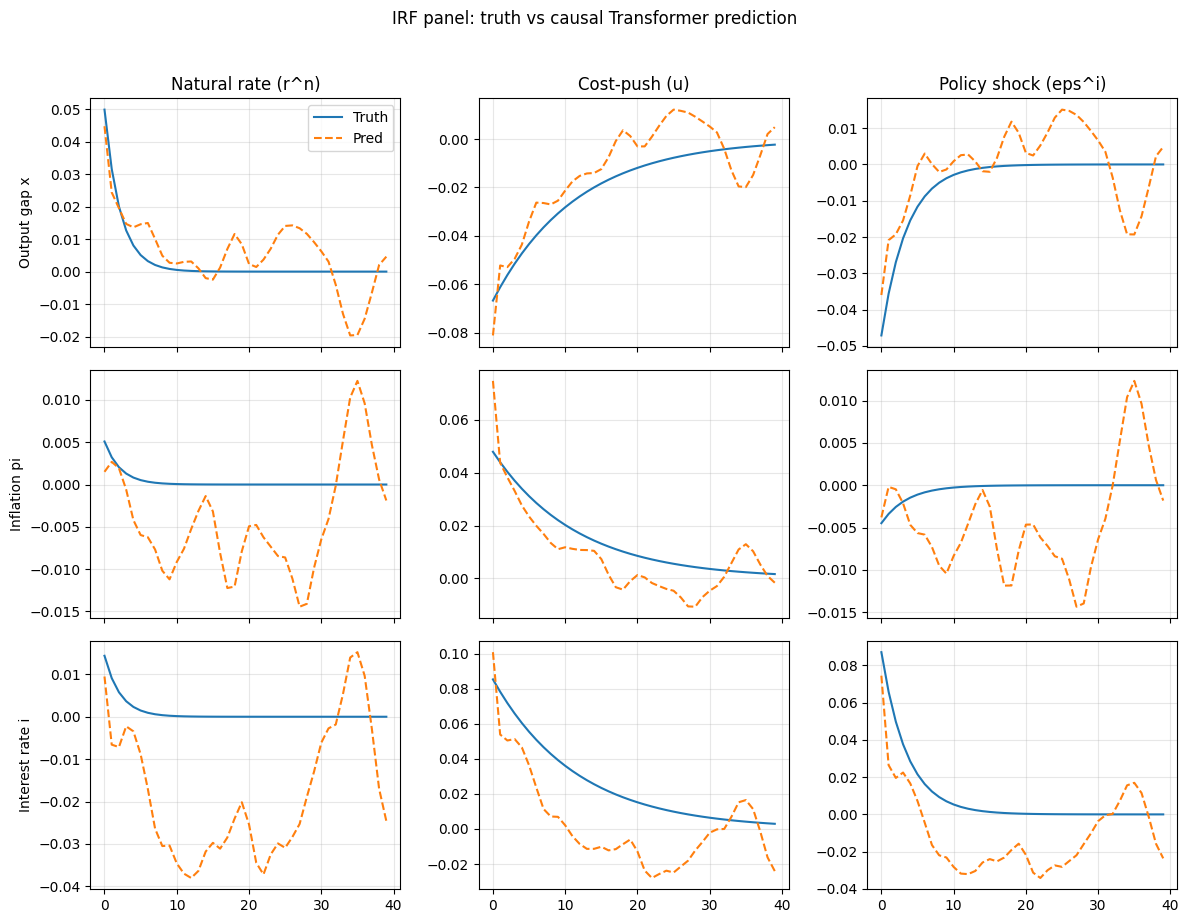

Avg IRF MSE across 3 shocks: 0.000264
IRF score across holdout thetas | mean=0.000163 median=0.000112 p90=0.000314


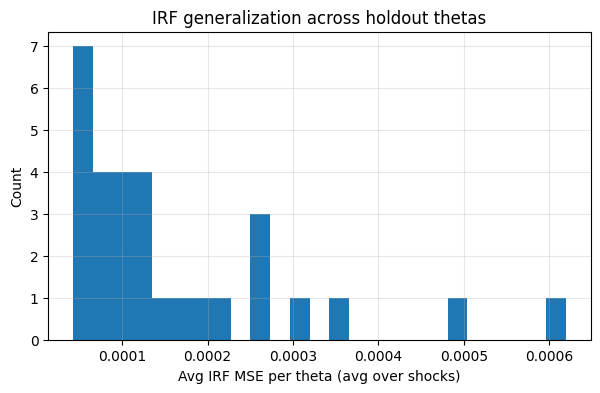

In [ ]:

p = random.choice(test_params)
print("Random holdout theta:", p)
plot_irf_panel(model, norm, p, H=40, impulse=1.0, device=device)

mses = irf_score_over_test(model, norm, test_params, H=40, impulse=1.0, device=device)

plt.figure(figsize=(7,4))
plt.hist(mses, bins=25)
plt.title("IRF generalization across holdout thetas")
plt.xlabel("Avg IRF MSE per theta (avg over shocks)")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()


Example 1/3 | out-of-sample MSE = 0.000261


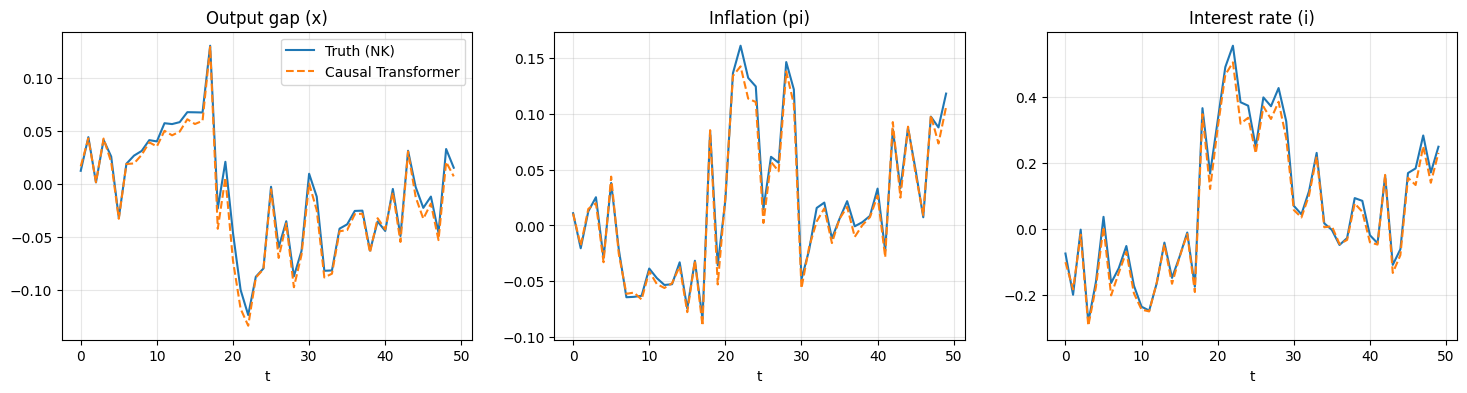

Example 2/3 | out-of-sample MSE = 0.000136


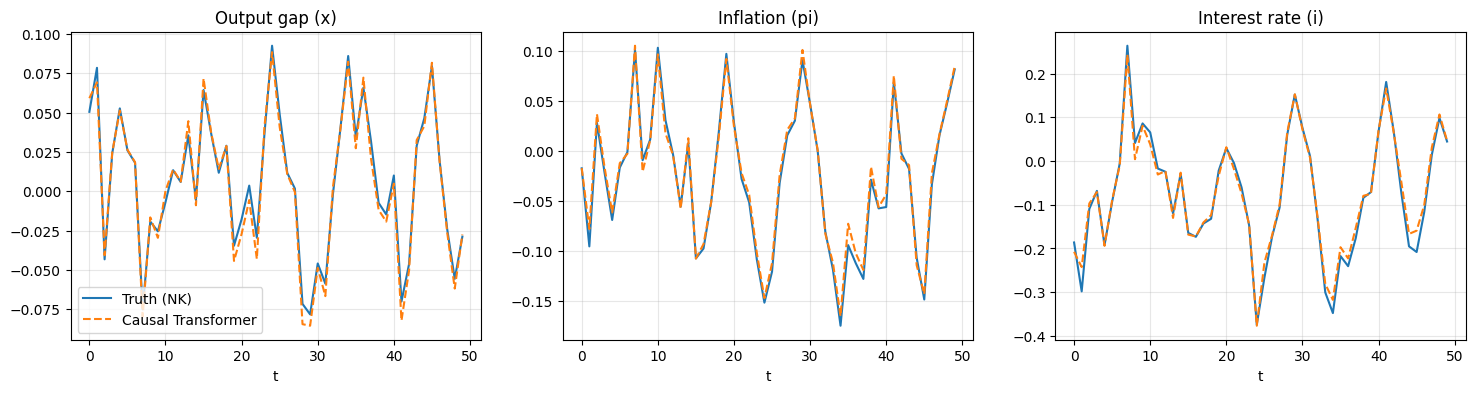

Example 3/3 | out-of-sample MSE = 0.000388


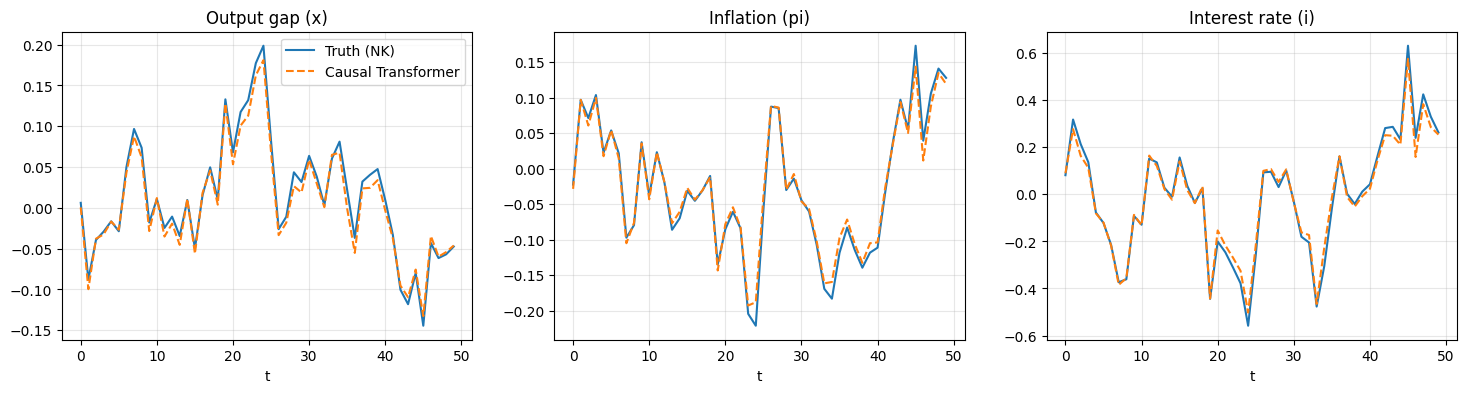

In [ ]:
# --- Qualitative out-of-sample trajectory examples (holdout thetas) ---

import numpy as np
import matplotlib.pyplot as plt
import random
import torch

def predict_on_params(model, norm: Normalizer, params: NKParams, T: int = 50):
    """
    Simulate a fresh sequence under holdout theta=params (NK truth),
    then run the trained causal model to predict y_t.

    Returns:
      y_true: (T,3)
      y_pred: (T,3)
    """
    ex = simulate_sequence(params, T=T)  # NK truth

    theta = ex.theta                 # (8,)
    innovations = ex.innovations     # (T,3)
    theta_tiled = np.tile(theta[None, :], (T, 1)).astype(np.float32)          # (T,8)
    x_in = np.concatenate([theta_tiled, innovations], axis=-1).astype(np.float32)  # (T,11)

    xb = torch.from_numpy(x_in).unsqueeze(0).to(device)  # (1,T,11)
    xb_n = (xb - norm.x_mean) / norm.x_std

    model.eval()
    with torch.no_grad():
        yhat_n = model(xb_n)                         # (1,T,3) normalized
        yhat = (yhat_n * norm.y_std + norm.y_mean)   # (1,T,3) original units

    y_pred = yhat.detach().cpu().numpy()[0]
    y_true = ex.targets
    return y_true, y_pred

n_examples = 3
T_plot = 50
names = ["Output gap (x)", "Inflation (pi)", "Interest rate (i)"]

for k in range(n_examples):
    p = random.choice(test_params)  # unseen theta by construction
    y_true, y_pred = predict_on_params(model, norm, p, T=T_plot)
    mse = float(np.mean((y_true - y_pred) ** 2))
    print(f"Example {k+1}/{n_examples} | out-of-sample MSE = {mse:.6f}")

    t = np.arange(T_plot)
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    for j, ax in enumerate(axes):
        ax.plot(t, y_true[:, j], label="Truth (NK)")
        ax.plot(t, y_pred[:, j], "--", label="Causal Transformer")
        ax.set_title(names[j])
        ax.set_xlabel("t")
        ax.grid(True, alpha=0.3)
    axes[0].legend()
    plt.show()